# refellips demo: Solid/Air
This demo presents a comparison between refellips and WVASE outputs as well as an example use case for fitting single-wavelength multi-angle ellipsometry data with refellips.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
from os.path import join as pjoin
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
from refnx.analysis import CurveFitter
from refnx.reflect import Slab

/Users/hayden/Documents/GitHub/refellips/demos/refnx/reflect/reflect_model.py:184: UserWarning: Can't use the C abeles backend
  warnings.warn("Can't use the C abeles backend")
/Users/hayden/Documents/GitHub/refellips/demos/refnx/reflect/reflect_model.py:196: UserWarning: Using the SLOW reflectivity calculation.
  warnings.warn("Using the SLOW reflectivity calculation.")


In [3]:
import refellips
from refellips.dataSE import DataSE, open_EP4file
from refellips.reflect_modelSE import ReflectModelSE
from refellips.objectiveSE import ObjectiveSE
from refellips.structureSE import RI

### Import data

In [4]:
#Ellipsomsetry data to model using refellips
pth = os.path.dirname(refellips.__file__)
dname = 'testData1_11nm_PNIPAM_on_Si_EP4.dat'
file_path = pjoin(pth, '../', 'demos', dname)
data = DataSE(data=file_path)

#Ellipsometry data modelled in WVASE
WVASE_test = pd.read_csv(open('WVASE_example_2nmSiO2_11nmPNIPAM_658nm.txt','r'))

### Build model

In [5]:
si     = RI(pjoin(pth, 'materials/silicon.csv'))
sio2   = RI(pjoin(pth, 'materials/silica.csv'))
PNIPAM = RI(A = 1.47, B = 0.00495)
air    = RI(pjoin(pth, 'materials/air.csv'))

polymer_layer = PNIPAM(150)
polymer_layer.name = 'PNIPAM'
polymer_layer.thick.setp(vary=True, bounds=(100,500))

silica_layer = sio2(20)
silica_layer.name = 'Silica'
silica_layer.thick.setp(vary=False, bounds=(1, 60))

struc = air(np.inf) | polymer_layer | silica_layer | si(np.inf)

model = ReflectModelSE(struc)

model.DeltaOffset.setp(value=0, vary=False, bounds=(-10,10))

# Comparison of refellips and WVASE outputs for a 2 nm SiO$_2$ and 15 nm PNIPAM system

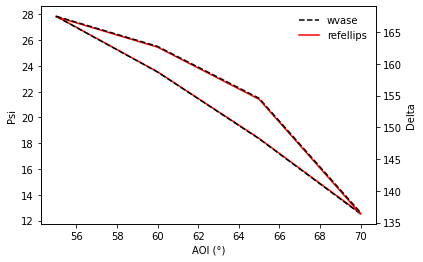

In [6]:
fig, ax = plt.subplots()
axt = ax.twinx()

wavelength_aois = np.c_[data.wavelength, data.aoi]
psi, delta = model(wavelength_aois)

ax.plot(WVASE_test['Angle of Incidence'], WVASE_test['Psi'],ls='--', color='k', zorder=5, label='wvase')
axt.plot(WVASE_test['Angle of Incidence'], WVASE_test['Delta'],ls='--', color='k', zorder=5)

ax.plot(wavelength_aois[:,1], psi, color='r', label='refellips')
axt.plot(wavelength_aois[:,1], delta, color='r')

ax.legend(frameon=False)
ax.set(ylabel='Psi', xlabel='AOI (°)')
axt.set(ylabel='Delta')
plt.show()

# Fitting experimental data

### Model & data pre fit

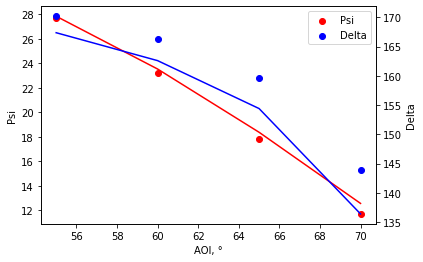

In [7]:
fig, ax = plt.subplots()
axt = ax.twinx()

for dat in data.unique_wavelength_data():
    wavelength, aois, psi_d, delta_d = dat
    wavelength_aois = np.c_[np.ones_like(aois) * wavelength, aois]

    psi, delta = model(wavelength_aois)
    ax.plot(aois, psi, color='r')
    p = ax.scatter(data.aoi, data.psi, color='r')

    axt.plot(aois, delta, color='b')
    d = axt.scatter(data.aoi, data.delta, color='b')

ax.legend(handles=[p,d], labels=['Psi', 'Delta'])
ax.set(ylabel='Psi', xlabel='AOI, °')
axt.set(ylabel='Delta')
plt.show()

In [8]:
objective = ObjectiveSE(model, data)

In [9]:
fitter = CurveFitter(objective)
fitter.fit(method='differential_evolution');

10it [00:00, 69.32it/s]


### Model & data post fit

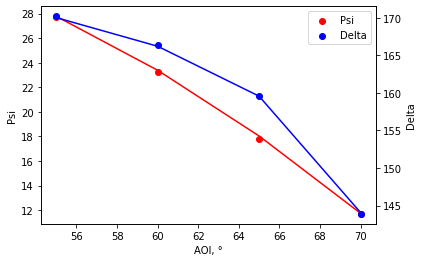

In [10]:
fig, ax = plt.subplots()
axt = ax.twinx()

wavelength_aois = np.c_[data.wavelength, data.aoi]
psi, delta = model(wavelength_aois)

psi, delta = model(wavelength_aois)
ax.plot(aois, psi, color='r')
p = ax.scatter(data.aoi, data.psi, color='r')

axt.plot(aois, delta, color='b')
d = axt.scatter(data.aoi, data.delta, color='b')

ax.legend(handles=[p,d], labels=['Psi', 'Delta'])
ax.set(ylabel='Psi', xlabel='AOI, °')
axt.set(ylabel='Delta')
plt.show()

In [11]:
for i, x in enumerate(objective.model.parameters):
    print(x)

________________________________________________________________________________
Parameters: 'instrument parameters'
<Parameter:'delta offset' , value=0 (fixed)  , bounds=[-10.0, 10.0]>
________________________________________________________________________________
Parameters: 'Structure - ' 
________________________________________________________________________________
Parameters:       ''       
<Parameter:  ' - thick'   , value=inf (fixed)  , bounds=[-inf, inf]>
<Parameter:  ' - rough'   , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter:' - volfrac solvent', value=0 (fixed)  , bounds=[0.0, 1.0]>
________________________________________________________________________________
Parameters:    'PNIPAM'    
<Parameter:  ' - thick'   , value=113.798 +/- 0.546, bounds=[100.0, 500.0]>
<Parameter: ' - cauchy A' , value=1.47 (fixed)  , bounds=[-inf, inf]>
<Parameter: ' - cauchy B' , value=0.00495 (fixed)  , bounds=[-inf, inf]>
<Parameter: ' - cauchy C' , value=0 (fixed)  , bounds=[-inf, 